In [180]:
import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from scipy.optimize import curve_fit

from structures_store import h5_load_structure
from cluster_multi_interfaces import follow_rabbits

In [3]:
structures = {}
with h5py.File("datasets/aggregated_structures_data.h5", 'r') as hf:
    for uniprot in tqdm(hf.keys()):
        structures[uniprot] = h5_load_structure(hf[uniprot])

100%|█████████████████████████████████████████████████████████████████████████| 20381/20381 [00:54<00:00, 371.26it/s]


In [26]:
# parameters
org_sel = "HUMAN"

sasa_dict = {}
with h5py.File("datasets/models.h5", 'r') as hf0:
    with h5py.File("datasets/solvent_accessible_surface_area.h5", 'r') as hf1:
        for uniprot in tqdm(hf1[org_sel].keys()):
            key = '{}/{}/F1'.format(org_sel, uniprot)
            resids = h5_load_structure(hf0[key])['resid']
            sasa = np.array(hf1[key]).astype(np.float32)
            sasa_dict[uniprot] = np.array([np.sum(sasa*(i == resids).astype(np.float32)) for i in np.unique(resids)])

100%|██████████████████████████████████████████████████████████████████████████| 20504/20504 [03:51<00:00, 88.57it/s]


In [17]:
# clustered interfaces
multi_interfaces_dict = json.load(open("datasets/clustered_multi_interfaces.json", 'r'))

In [21]:
# filter organism
npy_filepaths = glob("alphafold_pae/**/*.npy", recursive=True)
npy_filepaths = [fp for fp in npy_filepaths if "HUMAN" in fp]

In [365]:
# parameters
afs_thr = 70.0
labels_dict = {"protein":'p0', "dna/rna":'p1', "ion":'p2', "ligand":'p3', "lipid":'p4'}

# pack metrics
data = {'fold':[], 'interfaces':[]}
for npy_filepath in tqdm(npy_filepaths):
    uniprot = npy_filepath.split('/')[-1].split('-')[1]
    if (uniprot in structures) and (uniprot in sasa_dict):
        afs = structures[uniprot]['afs']
        sasa = sasa_dict[uniprot]
        D = np.load(npy_filepath).astype(np.float32)

        m_afs = (afs > afs_thr)
        Ds = D[m_afs,:][:,m_afs]
        if Ds.shape[0] > 0:
            data['fold'].append({
                'uniprot': uniprot,
                # all
                'size': afs.shape[0],
                'mafs': np.mean(afs),
                'sasa': np.sum(sasa),
                'mPAE': np.mean(D),
                # structured
                's_size': Ds.shape[0],
                's_mafs': np.mean(afs[m_afs]),
                's_sasa': np.sum(sasa[m_afs]),
                's_mPAE': np.mean(Ds),
                # combined
                'r_size': Ds.shape[0] / afs.shape[0],
            })

            for itype in labels:
                for ids in multi_interfaces_dict[uniprot][itype]:
                    Di = D[ids,:][:,ids]
                    data['interfaces'].append({
                        'uniprot': uniprot,
                        'itype': itype,
                        'size': len(ids),
                        'mPAE': np.mean(Di),
                        'sasa': np.sum(sasa[ids]),
                        'mafs': np.mean(afs[ids]),
                        'mpi': np.mean(structures[uniprot][labels_dict[itype]][ids]),
                    })

100%|█████████████████████████████████████████████████████████████████████████| 20296/20296 [00:39<00:00, 515.37it/s]


# Folds

In [366]:
dff = pd.DataFrame(data['fold'])
dff

,uniprot,size,mafs,sasa,mPAE,s_size,s_mafs,s_sasa,s_mPAE,r_size
0,Q8WXH4,323,88.225108,192.008545,11.462715,292,91.508699,162.401184,9.058241,0.904025
1,Q9NR46,395,78.013165,306.471100,18.336201,277,91.596534,170.795471,13.658509,0.701266
2,O15014,1411,45.183742,1773.558228,28.369436,146,85.059178,137.671967,22.452791,0.103473
3,Q969Q1,353,82.754929,318.109375,19.559631,287,90.971533,228.616028,16.937851,0.813031
4,Q96EG3,531,57.794972,554.850098,25.713121,231,86.040043,168.433533,16.887083,0.435028
...,...,...,...,...,...,...,...,...,...,...
19762,Q9NS64,109,60.914587,119.214111,19.754944,30,86.269667,28.528564,6.240160,0.275229
19763,Q9UNL4,249,76.898032,234.281158,20.207197,170,90.566295,129.918213,14.376769,0.682731
19764,P03951,625,86.046320,318.770844,15.751517,554,90.932960,248.348541,14.448336,0.886400
19765,Q29983,383,81.790000,288.718445,16.876024,293,92.461399,172.167282,9.894533,0.765013


## Structured to non-structured ratio

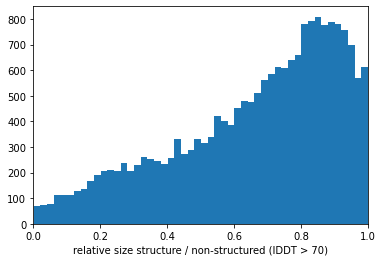

(0.6619928899731417, 0.7202680067001676)

In [367]:
x = dff['r_size'].values

plt.figure()
plt.hist(x, bins=50)
plt.xlim(0.0, 1.0)
plt.xlabel('relative size structure / non-structured (lDDT > 70)')
plt.show()

np.mean(r_sizes), np.median(r_sizes)

## Fold mean PAE as a function of structured / non-structured ratio

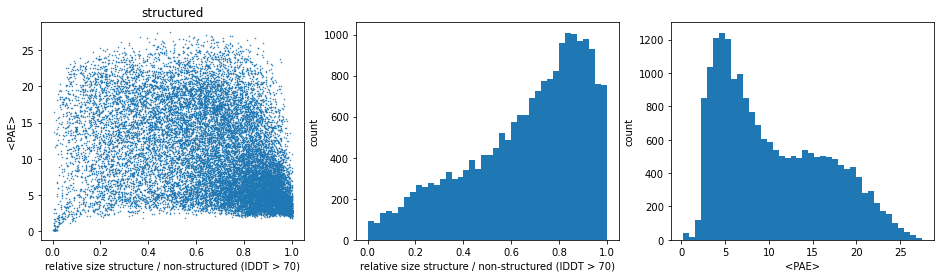

In [369]:
x = dff['r_size'].values
y = dff['s_mPAE'].values

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(x, y, '.', ms=1.0)
plt.title(itype)
plt.xlabel('relative size structure / non-structured (lDDT > 70)')
plt.ylabel('<PAE>')
plt.title('structured')

plt.subplot(132)
plt.hist(x, bins=40)
plt.xlabel('relative size structure / non-structured (lDDT > 70)')
plt.ylabel('count')

plt.subplot(133)
plt.hist(y, bins=40)
plt.xlabel('<PAE>')
plt.ylabel('count')
plt.show()

## Fold mean PAE as a function of size

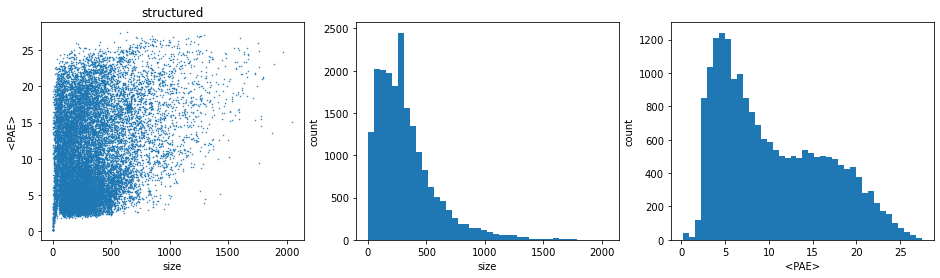

In [370]:
x = dff['s_size'].values
y = dff['s_mPAE'].values

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(x, y, '.', ms=1.0)
plt.title(itype)
plt.xlabel('size')
plt.ylabel('<PAE>')
plt.title('structured')

plt.subplot(132)
plt.hist(x, bins=40)
plt.xlabel('size')
plt.ylabel('count')

plt.subplot(133)
plt.hist(y, bins=40)
plt.xlabel('<PAE>')
plt.ylabel('count')
plt.show()

## Fold mean PAE as a function of sasa

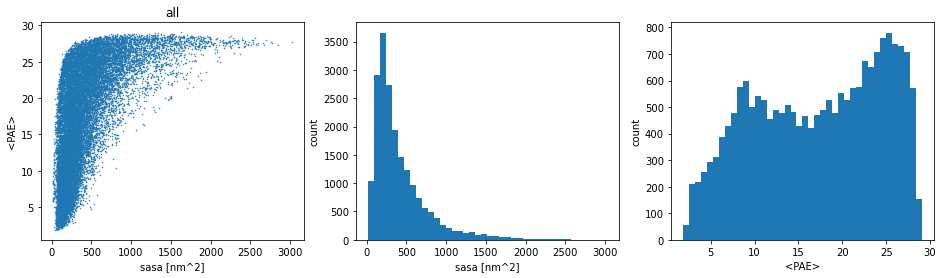

In [239]:
x = dff['sasa'].values
y = dff['mPAE'].values

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(x, y, '.', ms=1.0)
plt.title(itype)
plt.xlabel('sasa [nm^2]')
plt.ylabel('<PAE>')
plt.title('all')

plt.subplot(132)
plt.hist(x, bins=40)
plt.xlabel('sasa [nm^2]')
plt.ylabel('count')

plt.subplot(133)
plt.hist(y, bins=40)
plt.xlabel('<PAE>')
plt.ylabel('count')
plt.show()

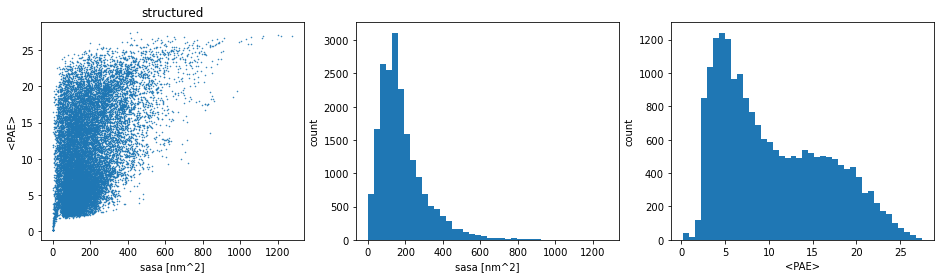

In [242]:
x = dff['s_sasa'].values
y = dff['s_mPAE'].values

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(x, y, '.', ms=1.0)
plt.title(itype)
plt.xlabel('sasa [nm^2]')
plt.ylabel('<PAE>')
plt.title('structured')

plt.subplot(132)
plt.hist(x, bins=40)
plt.xlabel('sasa [nm^2]')
plt.ylabel('count')

plt.subplot(133)
plt.hist(y, bins=40)
plt.xlabel('<PAE>')
plt.ylabel('count')
plt.show()

# Interfaces

In [229]:
# parmeters
min_size = 1
mpi_thr = 0.8

dfi = pd.DataFrame(data['interfaces'])

dfi = dfi[(dfi['size'] > min_size) & (dfi['mpi'] > mpi_thr)]
dfi

,uniprot,itype,size,mPAE,sasa,mafs,mpi
0,Q8WXH4,protein,24,5.534048,23.647259,76.839166,0.874682
2,Q8WXH4,protein,30,3.160109,24.357441,87.336000,0.868022
10,Q8WXH4,lipid,27,5.474619,25.387363,77.697037,0.911904
11,Q9NR46,protein,70,3.821029,51.507179,92.978714,0.890697
13,Q9NR46,protein,37,3.827988,27.671371,88.266216,0.870951
...,...,...,...,...,...,...,...
247452,Q9UNL4,ion,15,2.709810,6.244998,90.224001,0.958096
247456,P03951,ion,10,1.218892,2.505060,91.565000,0.866724
247473,Q29983,protein,28,3.748476,19.216085,92.502142,0.822260
247477,Q29983,protein,17,2.269914,14.909167,87.285882,0.805019


## Interface mean PAE as a function of interface size

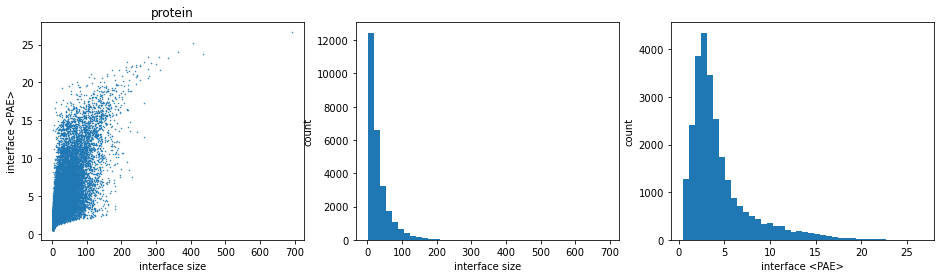

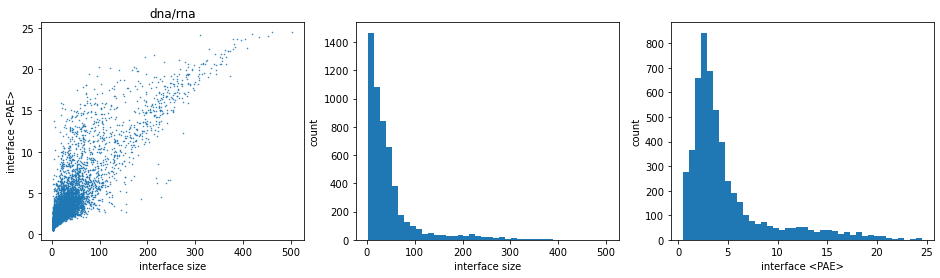

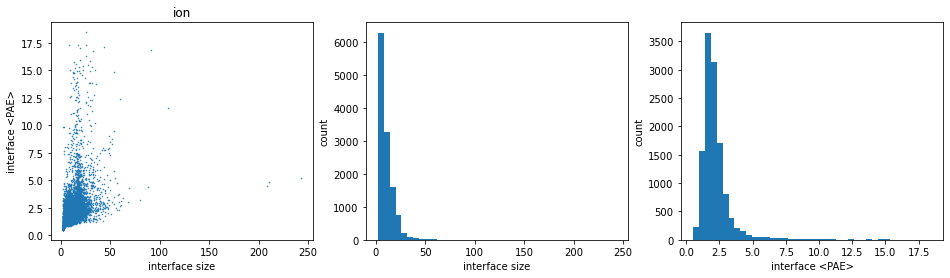

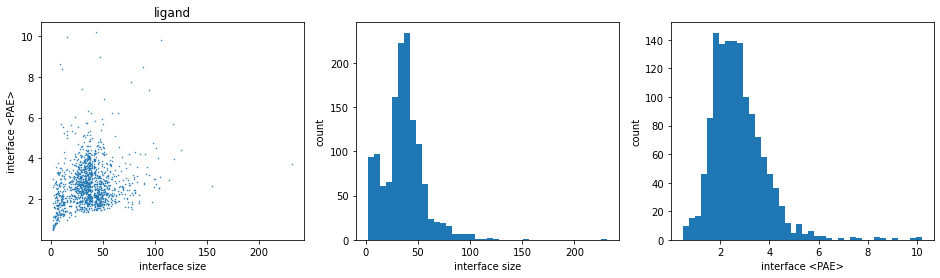

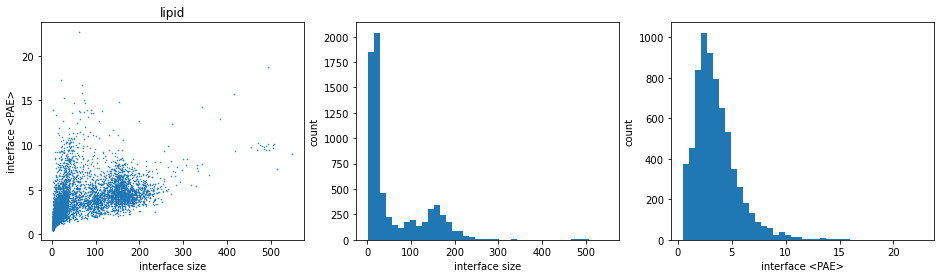

In [228]:
for itype in labels_dict:
    x = dfi[dfi['itype']==itype]['size']
    y = dfi[dfi['itype']==itype]['mPAE']
    
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.plot(x, y, '.', ms=1.0)
    plt.title(itype)
    plt.xlabel('interface size')
    plt.ylabel('interface <PAE>')

    plt.subplot(132)
    plt.hist(x, bins=40)
    plt.xlabel('interface size')
    plt.ylabel('count')
    
    plt.subplot(133)
    plt.hist(y, bins=40)
    plt.xlabel('interface <PAE>')
    plt.ylabel('count')
    plt.show()

## Interface mean PAE as a function of interface sasa

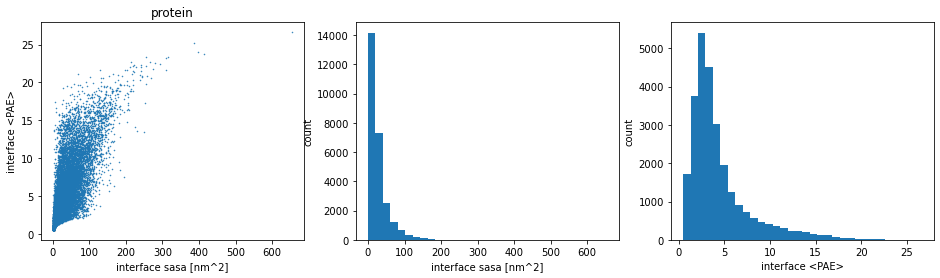

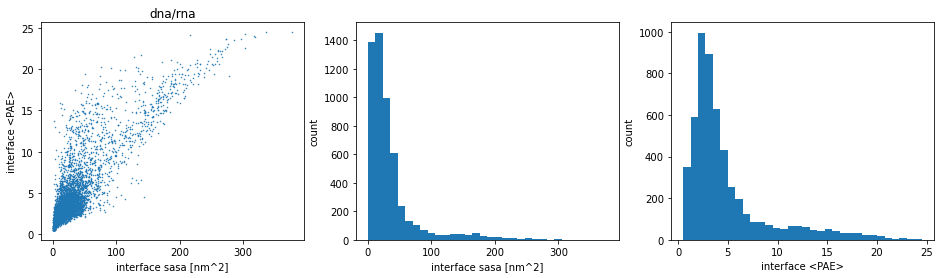

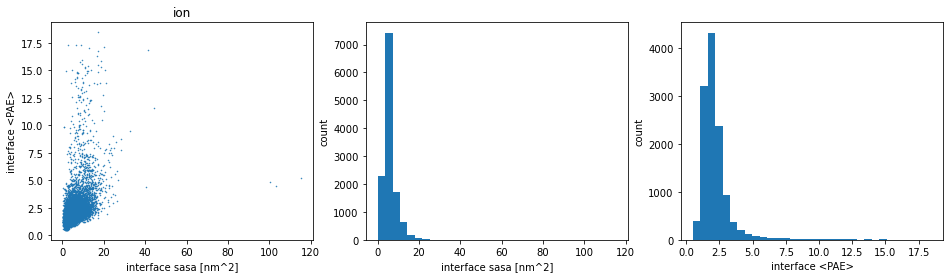

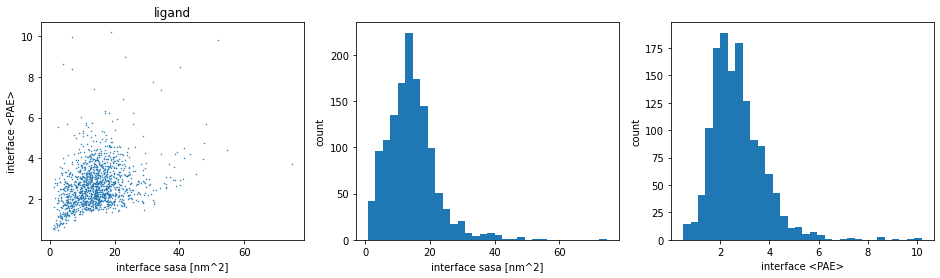

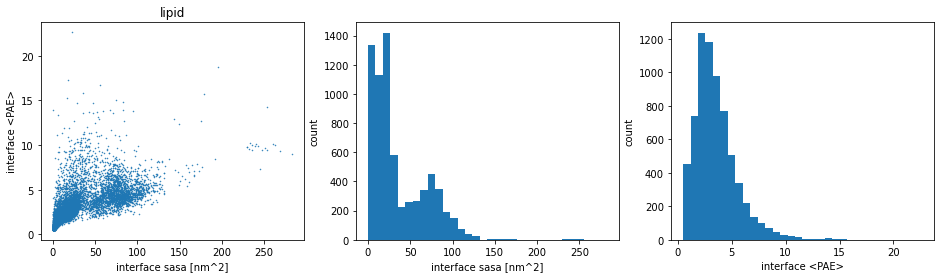

In [227]:
for itype in labels_dict:
    x = dfi[dfi['itype']==itype]['sasa']
    y = dfi[dfi['itype']==itype]['mPAE']
    
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.plot(x, y, '.', ms=1.0)
    plt.title(itype)
    plt.xlabel('interface sasa [nm^2]')
    plt.ylabel('interface <PAE>')

    plt.subplot(132)
    plt.hist(x, bins=32)
    plt.xlabel('interface sasa [nm^2]')
    plt.ylabel('count')
    
    plt.subplot(133)
    plt.hist(y, bins=32)
    plt.xlabel('interface <PAE>')
    plt.ylabel('count')
    plt.show()

## Interfaces geometry

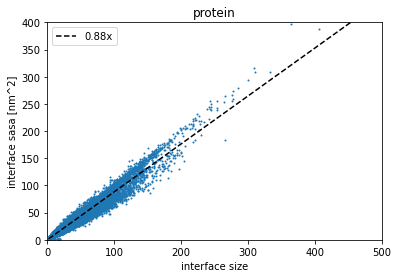

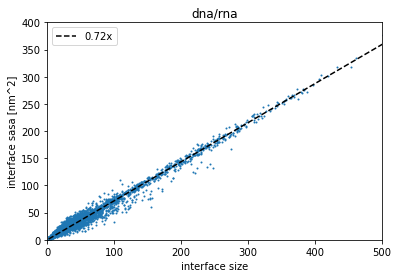

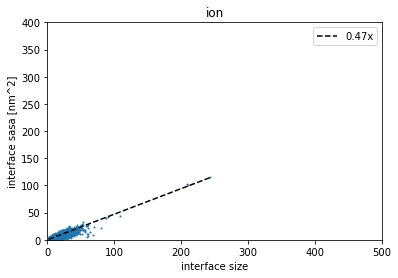

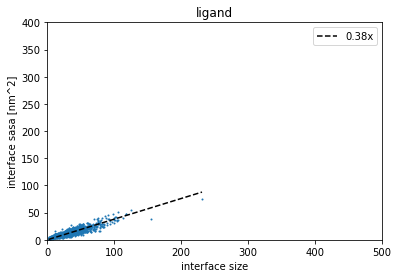

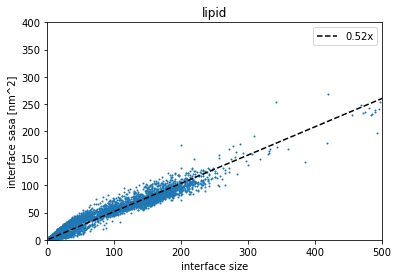

In [225]:
for itype in labels_dict:
    x = dfi[dfi['itype']==itype]['size'].values
    y = dfi[dfi['itype']==itype]['sasa'].values

    popt, pcov = curve_fit(lambda x,a: a*x, x, y)
    a = popt[0]
    err = np.sqrt(pcov[0][0])
    
    xf = np.linspace(np.min(x), np.max(x), 100)
    yf = a * xf
    
    plt.figure()
    plt.plot(x, y, '.', ms=2.0)
    plt.plot(xf, yf, 'k--', label="{:.2f}x".format(a))
    plt.legend(loc='best')
    plt.xlabel('interface size')
    plt.ylabel('interface sasa [nm^2]')
    plt.ylim(0.0, 400.0)
    plt.xlim(0.0, 500.0)
    plt.title(itype)
    plt.show()

## Criteria

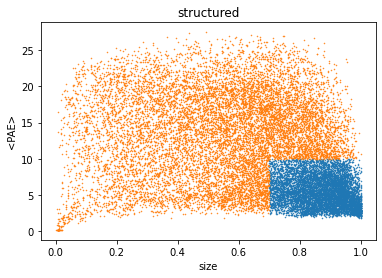

(0.3775990286841706, 7464, 19767)

In [386]:
# parameters
min_ratio_size = 0.7
max_mean_pae = 10.0

x = dff['r_size'].values
y = dff['s_mPAE'].values

m = ((x > min_ratio_size) & (y < max_mean_pae))
x0, y0 = x[m], y[m]
x1, y1 = x[~m], y[~m]

plt.figure()
plt.plot(x0, y0, '.', ms=1.0)
plt.plot(x1, y1, '.', ms=1.0)
plt.title(itype)
plt.xlabel('relative size')
plt.ylabel('<PAE> in structured region')
plt.show()

np.mean(m), np.sum(m), m.shape[0]

In [393]:
score = (dff['s_mPAE'] / dff['r_size']).values
dff['score'] = score
dff['selected'] = m.astype(float)
dff.sort_values('score').to_csv("datasets/selected_alphafold_models.csv", index=False)

In [392]:
uniprot_sel = dff['uniprot'].values[m]
dffs = dff[dff['uniprot'].isin(uniprot_sel)]
dfis = dfi[dfi['uniprot'].isin(uniprot_sel)]

## Interface mean PAE as a function of interface sasa

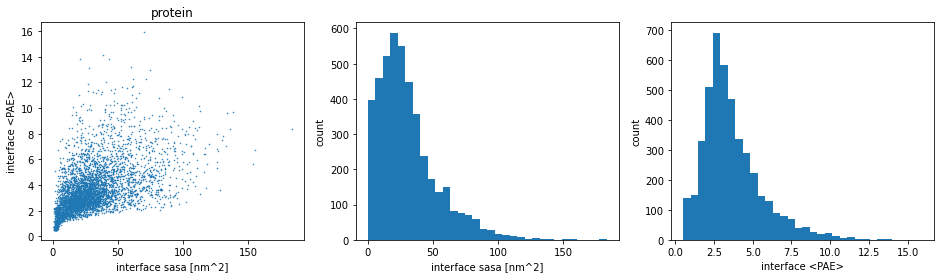

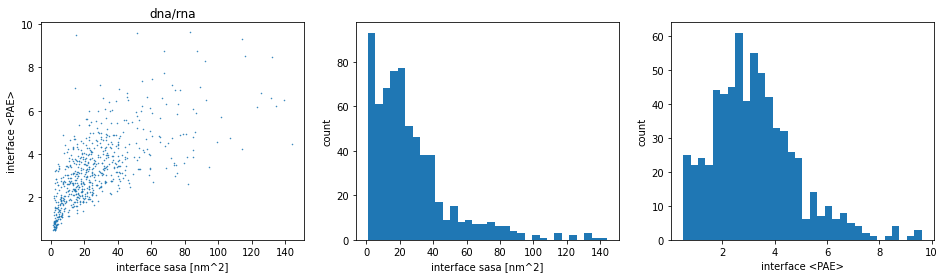

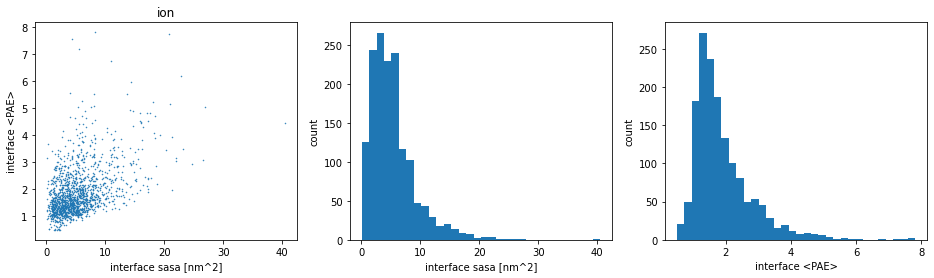

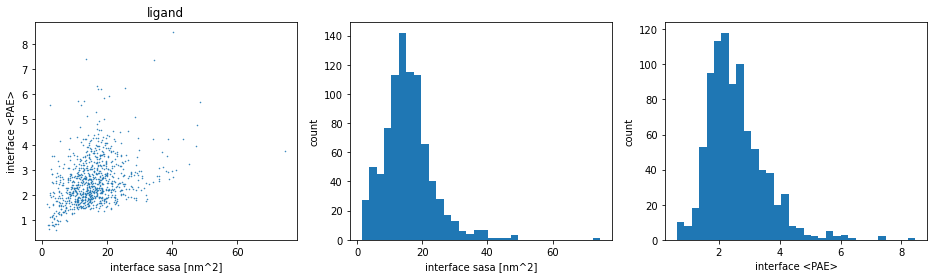

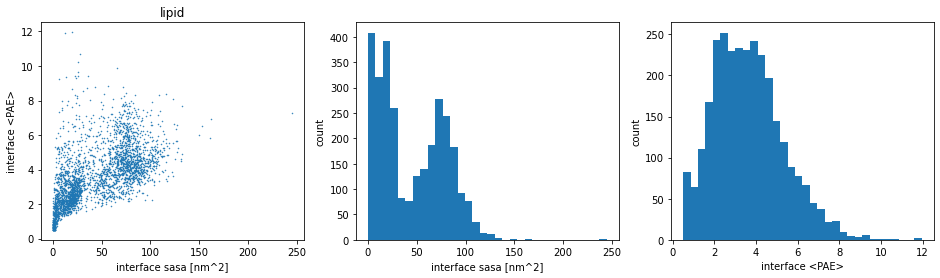

In [375]:
for itype in labels_dict:
    x = dfis[dfis['itype']==itype]['sasa']
    y = dfis[dfis['itype']==itype]['mPAE']
    
    plt.figure(figsize=(16,4))
    plt.subplot(131)
    plt.plot(x, y, '.', ms=1.0)
    plt.title(itype)
    plt.xlabel('interface sasa [nm^2]')
    plt.ylabel('interface <PAE>')

    plt.subplot(132)
    plt.hist(x, bins=32)
    plt.xlabel('interface sasa [nm^2]')
    plt.ylabel('count')
    
    plt.subplot(133)
    plt.hist(y, bins=32)
    plt.xlabel('interface <PAE>')
    plt.ylabel('count')
    plt.show()

## Interfaces geometry

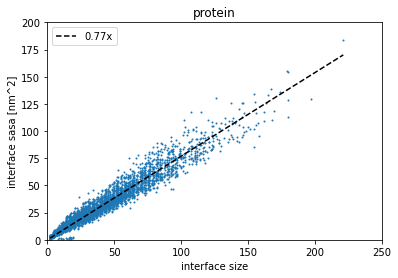

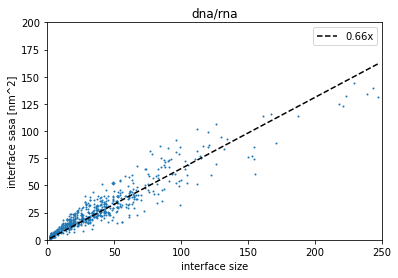

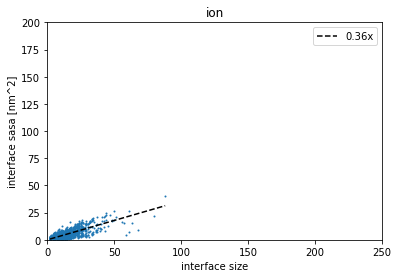

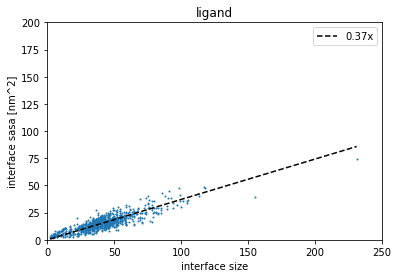

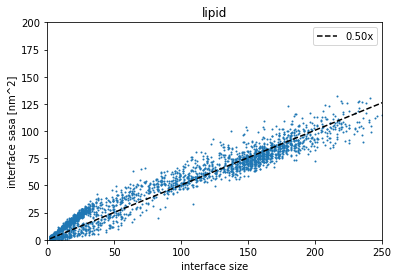

In [376]:
for itype in labels_dict:
    x = dfis[dfis['itype']==itype]['size'].values
    y = dfis[dfis['itype']==itype]['sasa'].values

    popt, pcov = curve_fit(lambda x,a: a*x, x, y)
    a = popt[0]
    err = np.sqrt(pcov[0][0])
    
    xf = np.linspace(np.min(x), np.max(x), 100)
    yf = a * xf
    
    plt.figure()
    plt.plot(x, y, '.', ms=2.0)
    plt.plot(xf, yf, 'k--', label="{:.2f}x".format(a))
    plt.legend(loc='best')
    plt.xlabel('interface size')
    plt.ylabel('interface sasa [nm^2]')
    plt.xlim(0.0, 250.0)
    plt.ylim(0.0, 200.0)
    plt.title(itype)
    plt.show()